In [1]:
!pip install scikit-learn
!pip install rasterio
!pip install earthpy
!pip install gdown
from glob import glob
import numpy as np
from scipy.io import loadmat
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
!cd ~
!gdown --id "1i5_vAMNI3PqD5nQwUN-zMXaSNo1r1qUm"

Downloading...
From: https://drive.google.com/uc?id=1i5_vAMNI3PqD5nQwUN-zMXaSNo1r1qUm
To: /tf/dataset1.zip
100%|████████████████████████████████████████| 122k/122k [00:00<00:00, 2.99MB/s]


In [5]:
!ls
!unzip ./dataset1.zip

Pavia_University_Model.h5  dataset1	 datasett      tensorflow-tutorials
aspiranturelogs		   dataset1.zip  datasett.zip
Archive:  ./dataset1.zip
replace dataset1/labels_test.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
files = glob("dataset1/*.png")
files.sort()
files

['dataset1/labels_test.png']

In [3]:
import skimage.io as io
# l = []
# for i in files:
#   with rio.open(i, 'r') as f:
#     l.append(f.read(0))
#     l.append(f.read(1))
#     l.append(f.read(2))
l = []
for i in files:
  im = plt.imread(i)
  l.append(im[:, :, 0])
  l.append(im[:, :, 1])
  l.append(im[:, :, 2])


In [155]:
#print(l)
# plt.imshow(ffd[0])
# ff = ffd[0]
# fff = ff[: , : , 0]
# print(fff.shape)
#print(ffd[0,:,:,0])
#plt.show()

In [4]:
arr_st = np.stack(l)

In [5]:
y_data=loadmat("dataset1/matlab.mat")["data"]

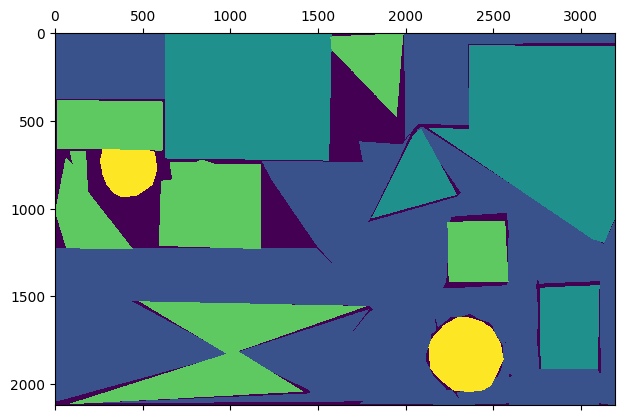

In [49]:
plt.matshow(y_data)
plt.show()

(2122, 3196)


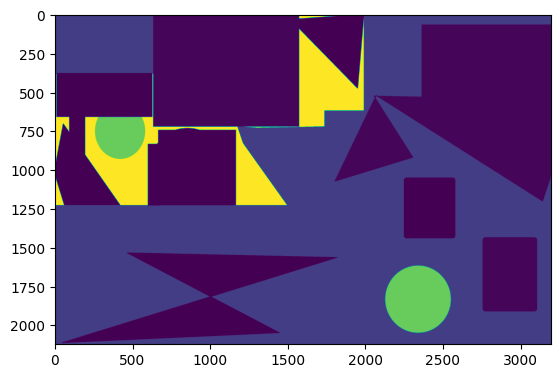

In [6]:
# ep.plot_rgb(
#     arr_st,
#     rgb=(3, 2, 1),
#     stretch=True,
#     str_clip=0.02,
#     figsize=(12, 16),
#     # title="RGB Composite Image with Stretch Applied",
# )

# plt.show()
tt = arr_st[2]
print(tt.shape)
tt
plt.imshow(tt)
plt.show()

In [7]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [8]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [9]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = False):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
def splitTrainTestSet(X, y, testRatio, randomState=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState)
    return X_train, X_test, y_train, y_test

In [11]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
dataset = 'SB'
test_size = 0.30
windowSize = 5
MODEL_NAME = 'Sundarbans'
path = '/content/drive/MyDrive/Sundarbans/'

X_data = np.moveaxis(arr_st, 0, -1)
#y_data = loadmat('Sundarbands_gt.mat')['gt']

# Apply PCA
K = 3
X,pca = applyPCA(X_data,numComponents=K)

print(f'Data After PCA: {X.shape}')

# Create 3D Patches
X, y = createImageCubes(X, y_data, windowSize=windowSize)
print(f'Patch size: {X.shape}')

print(f'test_size: {test_size}')

# Split train and test
#X_train, X_test, y_train, y_test = splitTrainTestSet(X, y, testRatio = test_size)
X_train = X[:int(len(X)*.8)]
y_train = y[:int(len(X)*.8)]
X_test = X[int(len(X)*.8):]
y_test = y[int(len(X)*.8):]
print("after train test")
X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)
print("after X")

# One Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(f'Train: {X_train.shape}\nTest: {X_test.shape}\nTrain Labels: {y_train.shape}\nTest Labels: {y_test.shape}')


Data After PCA: (2122, 3196, 3)
Patch size: (6781912, 5, 5, 3)
test_size: 0.3
after train test
after X
Train: (5425529, 5, 5, 3, 1)
Test: (1356383, 5, 5, 3, 1)
Train Labels: (5425529, 5)
Test Labels: (1356383, 5)


In [ ]:
np

<module 'numpy' from '/usr/local/lib/python3.8/dist-packages/numpy/__init__.py'>

In [12]:
from tensorflow import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
#from keras.optimizers import Adam
#from keras.callbacks import ModelCheckpoint
#from keras.utils import np_utils
#from tensorflow.keras.layers import 
# windowSize = 15 
# K = 1
S = windowSize
L = K
output_units = y_train.shape[1]

## input layer
input_layer = Input((S, S, L, 1))
print(input_layer)
## convolutional layers
conv_layer1 = Conv3D(filters=16, kernel_size=(2, 2, 1), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=32, kernel_size=(2, 2, 1), activation='relu')(conv_layer1)
conv2d_shape = conv_layer2.shape
conv_layer3 = Reshape((conv2d_shape[1], conv2d_shape[2], conv2d_shape[3]*conv2d_shape[4]))(conv_layer2)
conv_layer4 = Conv2D(filters=64, kernel_size=(2,2), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(128, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
dense_layer3 = Dense(20, activation='relu')(dense_layer2)
dense_layer3 = Dropout(0.4)(dense_layer3)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer3)

import tensorflow as tf
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)

# define the model with input layer and output layer
model = Model(name = dataset+'_Model' , inputs=input_layer, outputs=output_layer)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 3, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "SB_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 5, 3, 1)]      0         
                                                                 
 conv3d (Conv3D)             (None, 4, 4, 3, 16)       80        
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 3, 3, 32)       2080      
                                                                 
 reshape (Reshape)           (None, 3, 3, 96)          0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 64)          24640     
                                                                 
 flatten (Flatten)           (None, 25

In [14]:
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [15]:
ufdsa = keras_model_memory_usage_in_bytes(model, batch_size=128)
print(ufdsa)

1867501


In [16]:
#!export CUDA_VISIBLE_DEVICES=1
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333) 
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))
tf.config.experimental.get_memory_info('GPU:0')
from datetime import datetime
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
path="aspiranture"
# Callbacks
logdir = path+"logs/" +model.name+'_'+datetime.now().strftime("%d:%m:%Y-%H:%M:%S")

tensorboard_callback = TensorBoard(log_dir=logdir)

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 1,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model.fit(x=X_train, y=y_train, 
                    batch_size=64, epochs=6, 
                    validation_data=(X_test, y_test), callbacks = [tensorboard_callback, checkpoint])


Epoch 1/6
84774/84774 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9657
Epoch 1: val_loss improved from inf to 0.28439, saving model to Pavia_University_Model.h5
84774/84774 [==============================] - 744s 9ms/step - loss: 0.1608 - accuracy: 0.9657 - val_loss: 0.2844 - val_accuracy: 0.9398
Epoch 2/6
84773/84774 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9668
Epoch 2: val_loss did not improve from 0.28439
84774/84774 [==============================] - 752s 9ms/step - loss: 0.1554 - accuracy: 0.9668 - val_loss: 0.2959 - val_accuracy: 0.9389
Epoch 3/6
84770/84774 [============================>.] - ETA: 0s - loss: 0.1550 - accuracy: 0.9669
Epoch 3: val_loss did not improve from 0.28439
84774/84774 [==============================] - 732s 9ms/step - loss: 0.1550 - accuracy: 0.9669 - val_loss: 0.2904 - val_accuracy: 0.9424
Epoch 4/6
84768/84774 [============================>.] - ETA: 0s - loss: 0.1558 - accuracy: 0.9667
Epoch 4: 

<Figure size 1200x600 with 0 Axes>

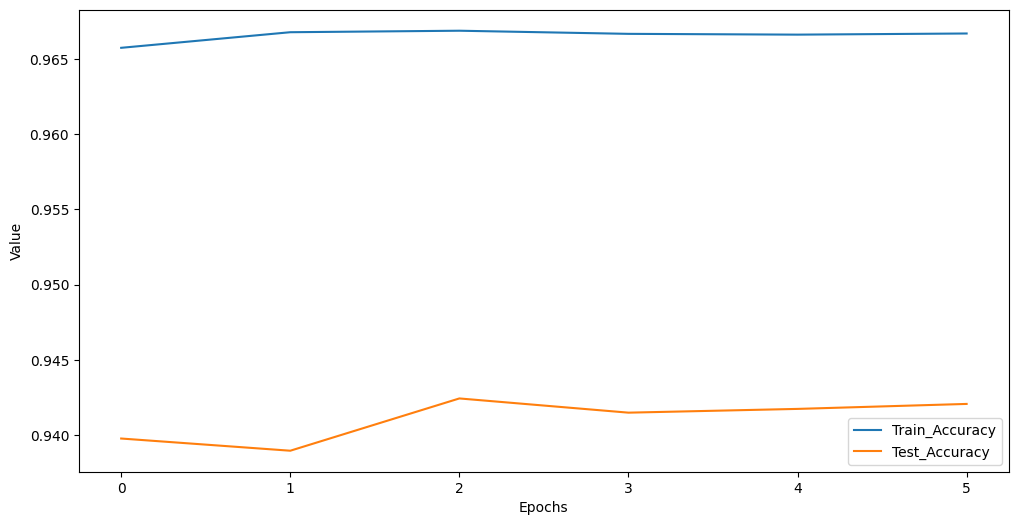

In [18]:
import pandas as pd
history11 = pd.DataFrame(history.history)

plt.figure(figsize = (12, 6))
plt.plot(range(len(history11['accuracy'].values.tolist())), history11['accuracy'].values.tolist(), label = 'Train_Accuracy')
# plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history11['val_accuracy'].values.tolist())), history11['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
# plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
188/188 [==============================] - 1s 5ms/step


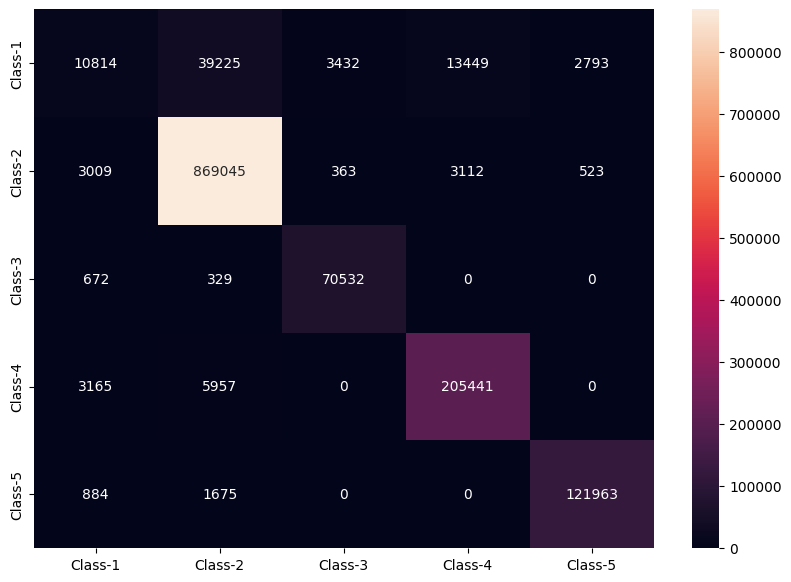

In [19]:
!pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred = model.predict(X_test, batch_size=1204*6, verbose=1)

plt.figure(figsize = (10,7))

classes = [f'Class-{i}' for i in range(1, 6)]

mat = confusion_matrix(np.argmax(y_test, 1),
                            np.argmax(pred, 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [20]:
!gdown --id "1evrBQtvdFV52dDkLVIr31pVr8aRfNOYz"
!unzip ./datasett.zip

Downloading...
From: https://drive.google.com/uc?id=1evrBQtvdFV52dDkLVIr31pVr8aRfNOYz
To: /tf/datasett.zip
100%|██████████████████████████████████████| 33.2k/33.2k [00:00<00:00, 2.37MB/s]
Archive:  ./datasett.zip
replace datasett/test.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [21]:
files_test = glob("datasett/*.png")
files_test.sort()
files_test

['datasett/test.png']

In [23]:
# lt = []
# for i in files_test:
#   with rio.open(i, 'r') as f:
#     lt.append(f.read(1))
lt = []
for i in files_test:
  im = plt.imread(i)
  lt.append(im[:, :, 0])
  lt.append(im[:, :, 1])
  lt.append(im[:, :, 2])

In [24]:
arr_tst = np.stack(lt)

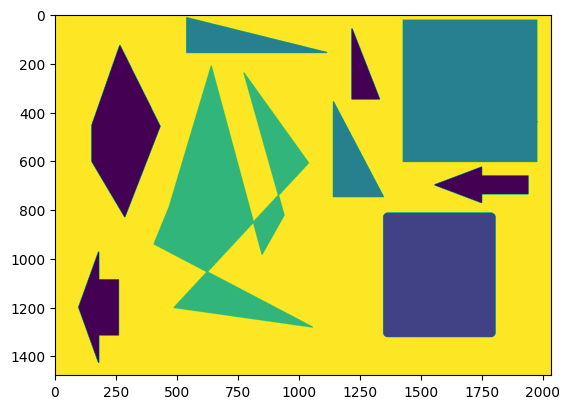

In [47]:
plt.imshow(lt[1])
plt.show()

In [26]:
X_data_validate = np.moveaxis(arr_tst, 0, -1)

In [27]:
X_validate,pca = applyPCA(X_data_validate,numComponents=K)

In [28]:
X_validate11, y = createImageCubes(X_validate, y_data, windowSize=windowSize)

In [29]:
X_validate111 = X_validate11.reshape(-1, windowSize, windowSize, K, 1)

In [30]:
pred_validate = model.predict(X_validate111, batch_size=128, verbose=1)

23487/23487 [==============================] - 61s 3ms/step


(3006252, 5)
39


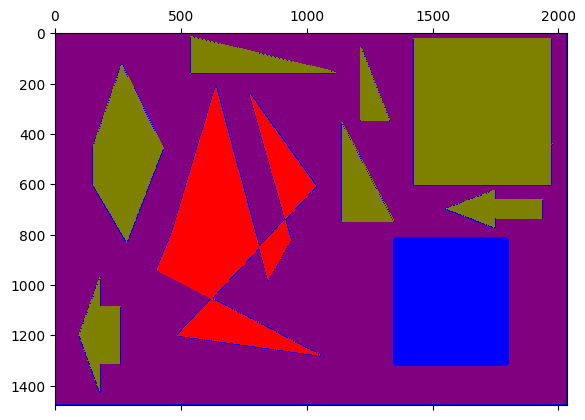

In [53]:
print(pred_validate.shape)
bb = np.argmax(pred_validate, 1)
print(np.count_nonzero(bb == 4))
bbb = bb.reshape(1478,2034)
# pred_vall = np.argmax(pred_validate,1)
#print(pred_vall)
#preed = pred_validate/pred_validate.max()
#fig = plt.figure(figsize=(6, 3.2))

#ax = fig.add_subplot(111)
#hh = np.array(pred_validate)
plt.matshow(bbb, cmap='brg')
plt.show()
#ww = lt[0]
#ww.shape
#preddd = pred_validate.reshape(1478, 2034)

In [ ]:
#print(pred)
pred1 = np.argmax(pred, axis=1)
print(pred1)
print(np.max(pred1))
print(np.size(pred1))
print(np.size(X_test))

#plt.matshow(pred1)

[1 1 1 ... 0 0 0]
4
1356383
109867023


In [ ]:
from sklearn.metrics import classification_report
y_pred_test = np.argmax(pred, axis=1)

classification = classification_report(np.argmax(y_test, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.55      0.29      0.38     69713
           1       0.95      0.99      0.97    876052
           2       0.95      0.98      0.96     71533
           3       0.96      0.94      0.95    214563
           4       0.97      0.98      0.98    124522

    accuracy                           0.94   1356383
   macro avg       0.88      0.84      0.85   1356383
weighted avg       0.93      0.94      0.94   1356383

